In [ ]:
# Importação das bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.__version__)


2.10.0


In [ ]:

# Configurando caminhos para os diretórios de treino, teste e validação para cada classe

dataset_dir = os.path.join(os.getcwd(), 'chest_xray')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_normal_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'NORMAL')))
dataset_train_pneumonia_len = len(os.listdir(
    os.path.join(dataset_train_dir, 'PNEUMONIA')))

dataset_test_dir = os.path.join(dataset_dir, 'test')
dataset_test_normal_len = len(os.listdir(
    os.path.join(dataset_test_dir, 'NORMAL')))
dataset_test_pneumonia_len = len(os.listdir(
    os.path.join(dataset_test_dir, 'PNEUMONIA')))

dataset_val_dir = os.path.join(dataset_dir, 'val')
dataset_val_normal_len = len(os.listdir(
    os.path.join(dataset_val_dir, 'NORMAL')))
dataset_val_pneumonia_len = len(os.listdir(
    os.path.join(dataset_val_dir, 'PNEUMONIA')))

In [ ]:

# Exibindo quantidade de imagens por dataset

print('Training Normal: %s' % dataset_train_normal_len)
print('Training Pneumonia: %s' % dataset_train_pneumonia_len)
print('Test Normal: %s' % dataset_test_normal_len)
print('Test Pneumonia: %s' % dataset_test_pneumonia_len)
print('Validation Normal: %s' % dataset_val_normal_len)
print('Validation Pneumonia: %s' % dataset_val_pneumonia_len)

Training Normal: 1342
Training Pneumonia: 3876
Test Normal: 234
Test Pneumonia: 390
Validation Normal: 17
Validation Pneumonia: 18


In [ ]:
# Configurando variáveis

image_width = 160
image_height = 160


image_color_channel = 1
image_color_channel_size = 3
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel, )


batch_size = 32
epochs = 20
learning_rate = 0.001

class_names = ['normal', 'pneumonia']


In [ ]:
# Carregando dataset de treino 

dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True,
)


Found 5216 files belonging to 2 classes.


In [ ]:
# Carregando dataset de validação

dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_val_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 33 files belonging to 2 classes.


In [ ]:
# Carregando dataset de teste

dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_test_dir,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 624 files belonging to 2 classes.


In [ ]:
# Pré-processamento das imagens realizando redimensionamento, espelhamento e conversão para escala de cinza

def preprocess_image(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    
    image = tf.image.rgb_to_grayscale(image)
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label
  
dataset_train = dataset_train.map(preprocess_image)
dataset_test = dataset_test.map(preprocess_image)
dataset_validation = dataset_validation.map(preprocess_image)


In [ ]:
# função para plotar imagens do dataset de forma aleatória
 
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            

<Figure size 640x480 with 0 Axes>

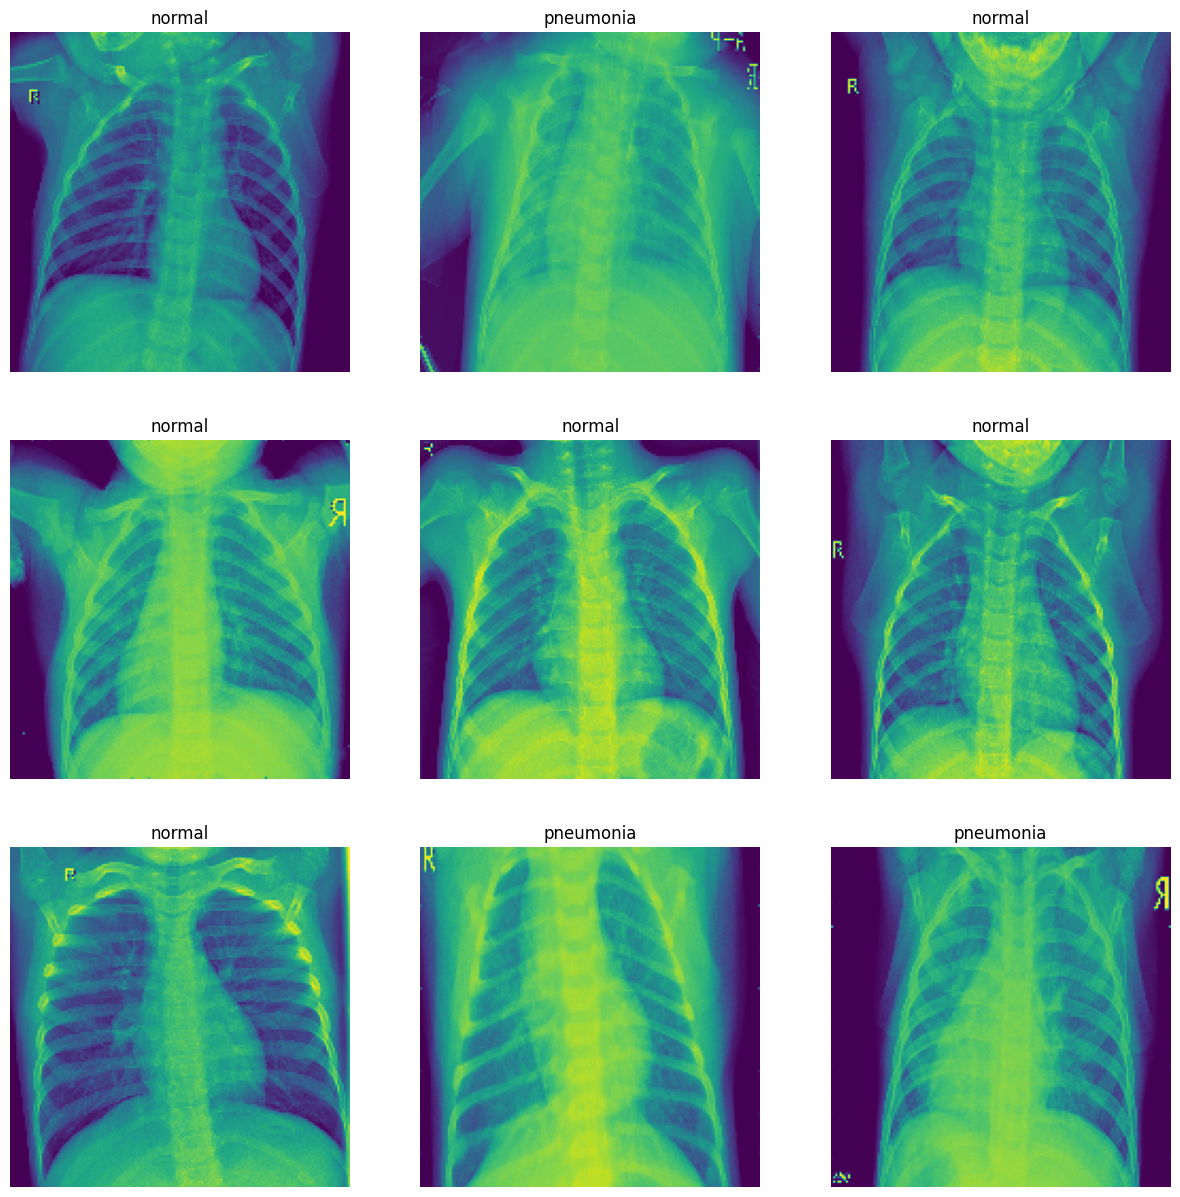

In [ ]:
plot_dataset(dataset_validation)

<Figure size 640x480 with 0 Axes>

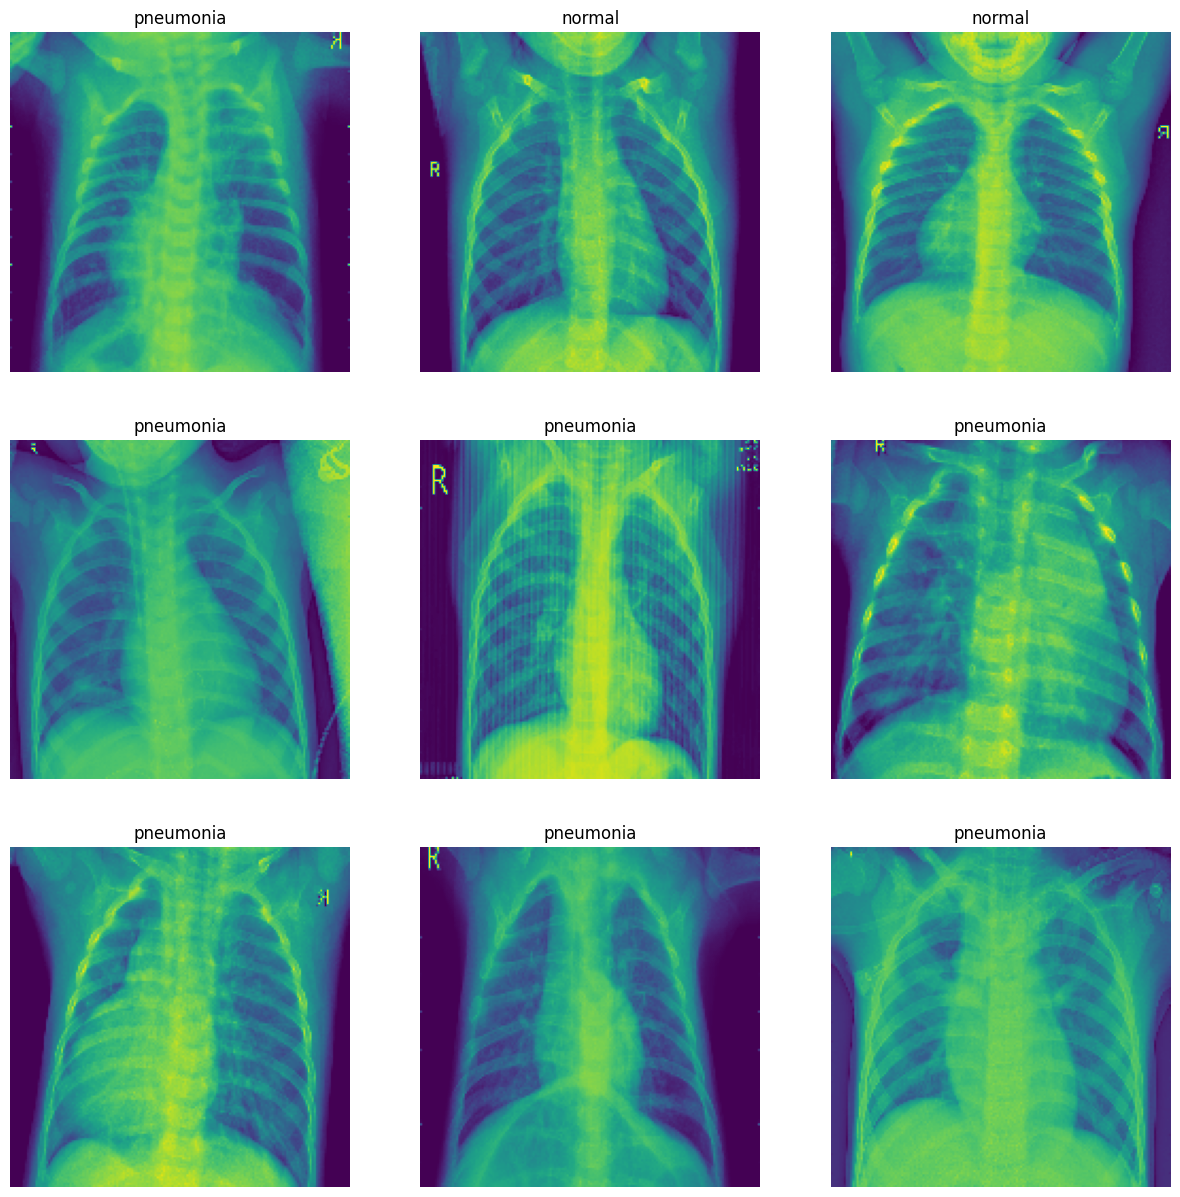

In [ ]:
plot_dataset(dataset_test)

<Figure size 640x480 with 0 Axes>

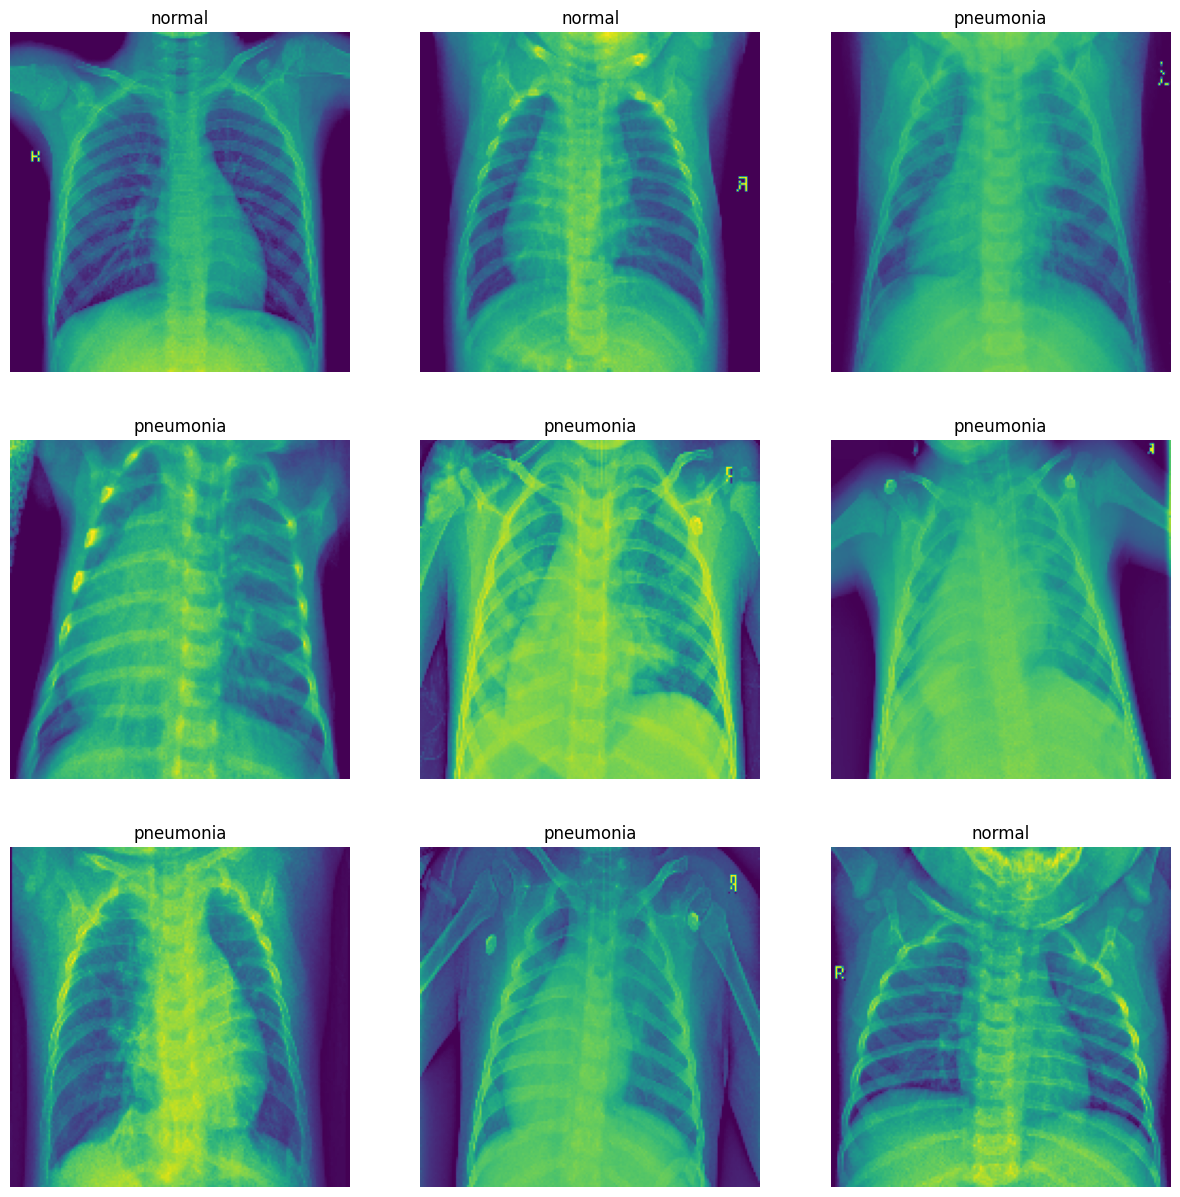

In [ ]:
plot_dataset(dataset_train)

In [ ]:
# Realizando data augmentation para aumentar a quantidade de imagens no dataset de treino

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])


In [ ]:
# função para plotar imagens do dataset de forma aleatória após data augmentation

def plot_dataset_data_augmentation(dataset):
  plt.gcf().clear()
  plt.figure(figsize=(15, 15))
  
  for features, _ in dataset.take(1):
    feature = features[0]
    
    for i in range(9):
      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
      
      plt.subplot(3, 3, i + 1)
      plt.axis('off')
      
      plt.imshow(feature_data_augmentation[0]  / image_color_channel_size)
      
      

<Figure size 640x480 with 0 Axes>

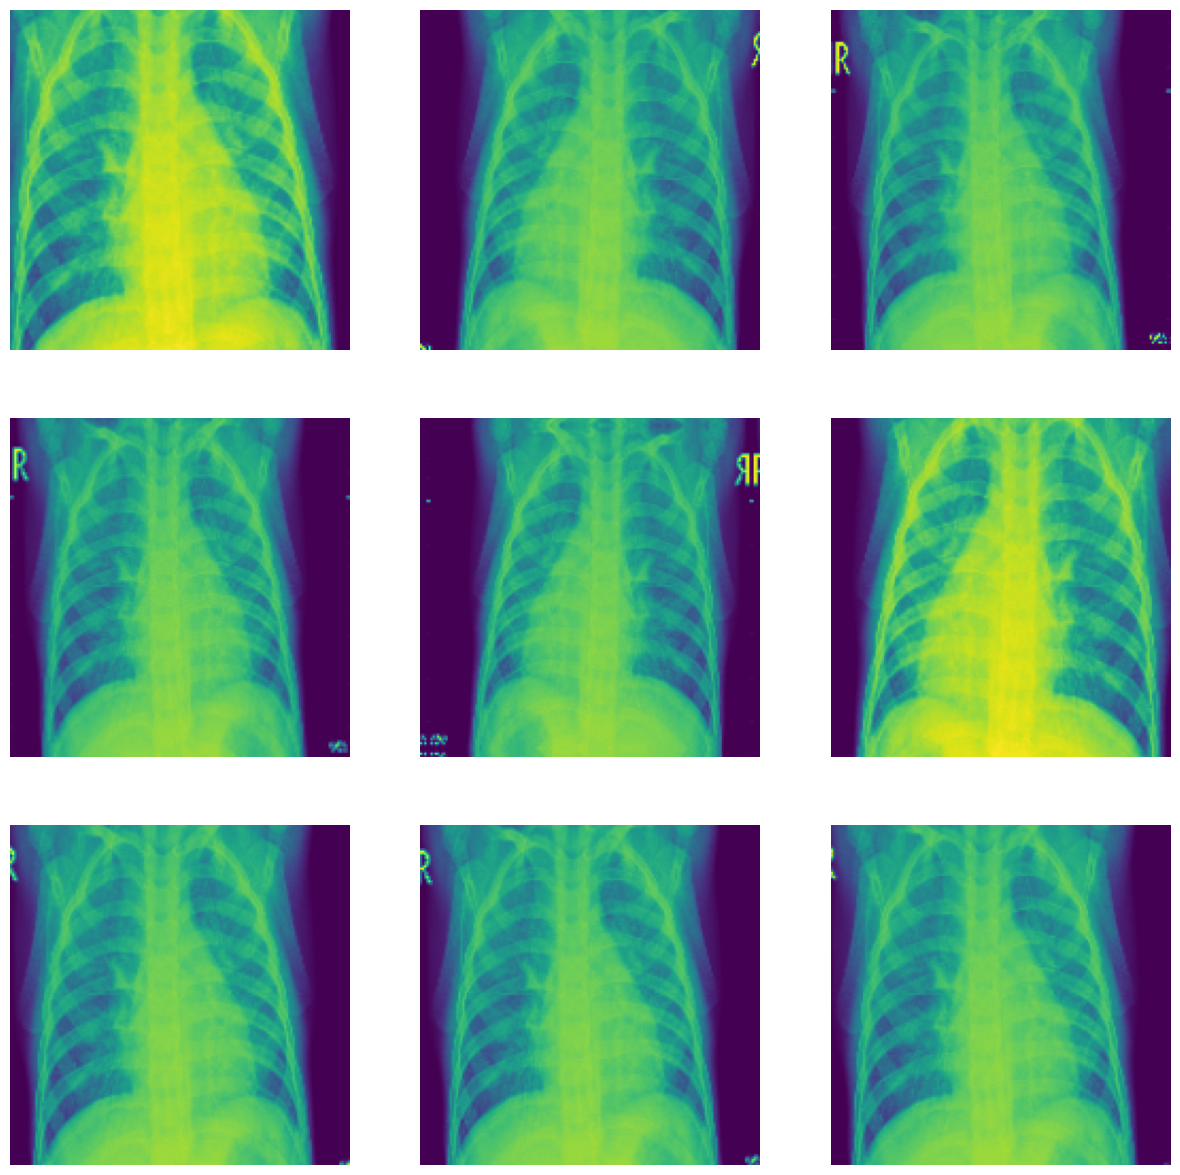

In [ ]:
plot_dataset_data_augmentation(dataset_validation)

In [ ]:
# Criando modelo de rede neural convolucional com 4 camadas convolucionais e 2 camadas densas


model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size,
        input_shape=image_shape
    ),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 160, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                  

In [ ]:
# Realizando treinamento do modelo e salvando o histórico de treinamento


history = model.fit(
  dataset_train,
  validation_data=dataset_validation,
  epochs=epochs,
)


Epoch 1/20
163/163 [==============================] - 39s 193ms/step - loss: 1.7813 - accuracy: 0.8541 - val_loss: 0.4371 - val_accuracy: 0.8485
Epoch 2/20
163/163 [==============================] - 24s 144ms/step - loss: 0.1780 - accuracy: 0.9329 - val_loss: 0.1684 - val_accuracy: 0.9091
Epoch 3/20
163/163 [==============================] - 24s 143ms/step - loss: 0.1694 - accuracy: 0.9337 - val_loss: 1.0416 - val_accuracy: 0.6970
Epoch 4/20
163/163 [==============================] - 24s 142ms/step - loss: 0.1489 - accuracy: 0.9436 - val_loss: 0.1804 - val_accuracy: 0.9394
Epoch 5/20
163/163 [==============================] - 24s 142ms/step - loss: 0.1330 - accuracy: 0.9509 - val_loss: 0.6003 - val_accuracy: 0.6970
Epoch 6/20
163/163 [==============================] - 25s 148ms/step - loss: 0.1175 - accuracy: 0.9569 - val_loss: 0.5341 - val_accuracy: 0.8182
Epoch 7/20
163/163 [==============================] - 26s 154ms/step - loss: 0.1228 - accuracy: 0.9540 - val_loss: 0.0957 - val_ac

In [ ]:
# função para plotar gráficos de acurácia e loss do modelo


def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs_range = range(epochs)
  
  plt.gcf().clear()
  plt.figure(figsize=(15,8))
  
  plt.subplot(1,2,1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  
  plt.subplot(1,2,2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  
  plt.show()

<Figure size 640x480 with 0 Axes>

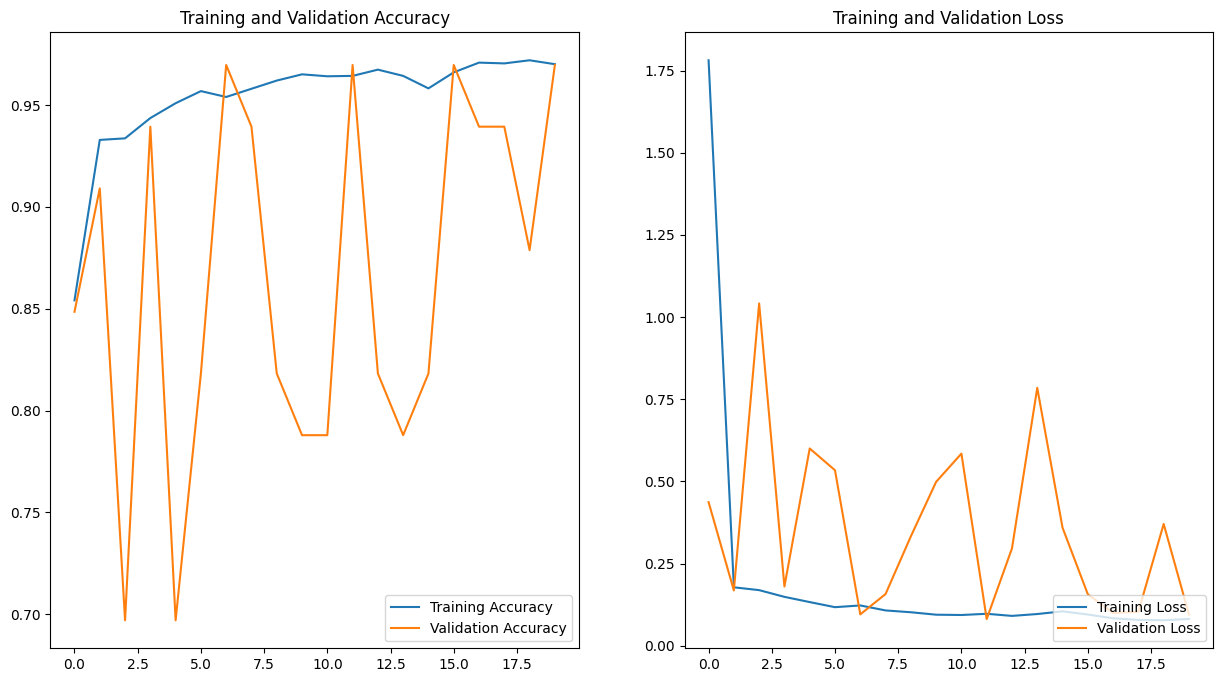

In [ ]:
plot_model()

In [ ]:
# função para plotar imagem do dataset de teste com a predição do modelo

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if(predicted_label == true_label):
        color = 'black'
    else:
        color = 'red'

    plt.title("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(predictions_array),
        class_names[true_label]),
        color=color)
    

# Função para plotar o resultado do modelo com 25 imagens aleatórias do dataset de teste

def plot_results(predictions, labels, images):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    len = predictions.shape[0]

    arrayindex = random.sample(range(len), 25)

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plot_image(arrayindex[i], predictions[arrayindex[i]], labels, images)
        


1/1 [==============================] - 0s 18ms/step


<Figure size 640x480 with 0 Axes>

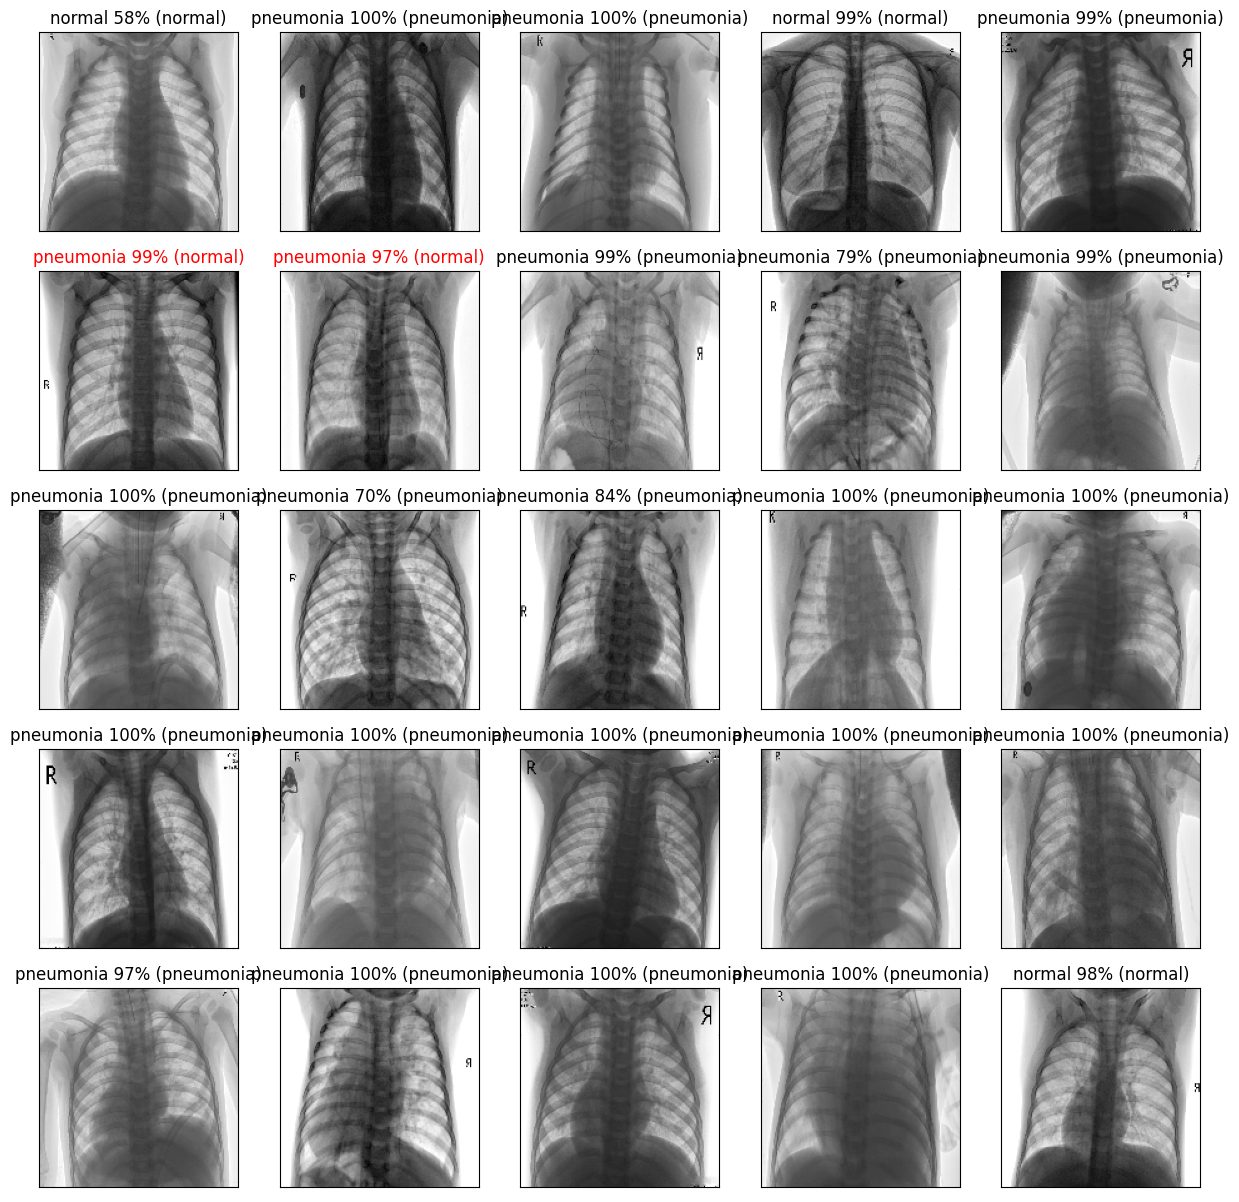

In [ ]:
features, labels = dataset_test.as_numpy_iterator().next()
predictions = model.predict(features)

plot_results(predictions, labels, features)

In [ ]:
# model.save('models/x_ray_v2.h5')

In [ ]:
# model = tf.keras.models.load_model('models/x_ray_v1.h5')